<hr>

# An Introduction to Quaternions
_Promoting methodological diversity in spatial rotation._

<hr>
Falk Mielke, Functional Morphology, Universiteit Antwerpen

You can download this notebook [here](user://notebooks/Quaternions.ipynb?download&target=_blank).

# Table of Content <a class="anchor" id="toc"></a>


- [Introductory Video](#intro)
- [Code](#code)
- [Advanced Functions](#advanced)
- [Application: Joint Configuration Space](#app)



# Introductory Video <a class="anchor" id="intro"></a> 
([^](#toc) top) 

Over at [SICB 2021](https://sicbannualmeeting.pathable.co/meetings/virtual/CvMZEsFqMNDqTfAF8?target=_blank), I had a good time watching the many excellent videos of colleagues, and engaged in some discussions.

Quite a few people presented work which relied on rotation in 3D space. 
To my surprise, most of them used Euler angles, although [some consider those to be evil](https://www.sjbaker.org/steve/omniv/eulers_are_evil.html?target=_blank). 

I decided to produce a brief overview of how I have been handling spatial rotation for my work on inverse dynamics. 
It became a "bonus 6 min talk", a kind of supplement for my presentation. 

Enjoy watching!

Further below, you will find code, and my humble attempt to apply quaternions to quantify (distances in) joint configuration space (or "range of motion"/ROM).




<video src="images/spatial_rotation.webm" poster="images/spatial_rotation.png" width="800" controls>
</video> 

The video is [also available on youtube](https://youtu.be/uUFmK91QpN0?target=_blank).

Links to related videos which I mention:
- [https://www.youtube.com/watch?v=4HDRdUvwSnU](https://www.youtube.com/watch?v=4HDRdUvwSnU&target=_blank) (animation by  Grant Sandersonand Ben Eater )
- [https://www.youtube.com/watch?v=mHVwd8gYLnI](https://www.youtube.com/watch?v=mHVwd8gYLnI&target=_blank) (lecture by Ken Joy)

---

# Code; Pitfalls Included! <a class="anchor" id="code"></a> 
([^](#toc) top) 

There are three implementations of the quaternion concept which I use regularly. 
Many others exist. 
I never did a thorough comparison of libraries, because the ones below worked out of the box. 


In [1]:
import numpy as NP
import sympy as SYM

NP.set_printoptions(precision = 4)
NP.random.seed(123)

### (A): `sympy` algae-bra's
*(mermaid fashion joke)*

Found [here](https://docs.sympy.org/latest/modules/algebras.html).

Symbolic computing is useful for the analytical solution of physics problems. 
You can find several examples on this blog. 

Let's review some quaternion attributes in symbolic computing.

In [2]:
from sympy.algebras.quaternion import Quaternion as SQ

θ, x, y, z = SYM.symbols('θ, x, y, z')

q = SQ(SYM.cos(θ/2), x*SYM.sin(θ/2), y*SYM.sin(θ/2), z*SYM.sin(θ/2))
q.conjugate()

cos(θ/2) + (-x*sin(θ/2))*i + (-y*sin(θ/2))*j + (-z*sin(θ/2))*k

This is the ugly real/imaginary face of a quaternion.
Do you already begin to see axis and angle in there?

**Let's rotate a point!**


In [3]:
# define the point
p = SYM.symbols('p_:3')
SYM.pprint(p)

# substitutions
subs = {p[0]: 5., p[1]: 0, p[2]: 0 \
       , θ: NP.arctan2(3, 4), x: 0, y: 0, z: 1 \
       }

# And here comes the rotation, with our example values substituted:
[elm.subs(subs) for elm in SQ.rotate_point([*p], q)]

(p₀, p₁, p₂)


[4.00000000000000, 3.00000000000000, 0]

There are more functions worth exploring: for example, quaternions can be generated from rotation matrices with the  `from_rotation_matrix` function.

Yet my most frequent application lies in using quaternions for the orientation of reference frames (with [`sympy.physics.vector.frame.ReferenceFrame.orientnew`](https://docs.sympy.org/latest/modules/physics/vector/api/classes.html#sympy.physics.vector.frame.ReferenceFrame.orientnew?target=_blank)).

### (B): `scipy` rotation

The `scipy` toolbox contains [a module for spatial rotations](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.transform.Rotation.html?target=_blank). 


In [4]:
from scipy.spatial.transform import Rotation as ROT

This rotation object can be generated from any input:
- `ROT.from_quat(...)`
- `ROT.from_matrix(...)`
- `ROT.from_euler(...)`
- (and others)

Then, once initialized it can be converted to other representations.
- `r.as_quat()`
- `r.as_matrix()`
- `r.as_euler()`

Example:
Generate a quaternion which rotates by $\approx 37deg$ around the z axis; make sure that the real part comes first.

In [5]:
θ = NP.arctan2(3, 4)
r = ROT.from_euler('z', θ, degrees = False)
print (NP.roll(r.as_quat(),1))


[0.9487 0.     0.     0.3162]


**Attention:** as you noticed, I had to `roll` the quaternion to get the $( q_w, q_x, q_y, q_z )$ order. 
For some reason that is not clear to me, `scipy` developers designed the rotation object to store the "real" component $q_w$ last.

Conversely, to get the correct rotation matrix, one has to enter the quaternion in the order that `scipy` demands.

In [6]:
r = ROT.from_quat([0, 0, NP.sin(θ/2), NP.cos(θ/2)])
print (r.as_matrix())

[[ 0.8 -0.6  0. ]
 [ 0.6  0.8  0. ]
 [ 0.   0.   1. ]]



Lesson learned: *always read the documentation!* (As usual, I didn't carefully read, then it took me two days to find the error.)

When properly defined, we can rotate the test point from the video.

In [7]:
r.apply(NP.array([5,0,0]))

array([4., 3., 0.])

I use `scipy.spatial.transform.Rotation` for most conversions of numerical values between the different rotational representations. 

### (C) `numpy`-quaternion

Installing [the `numpy-quaternion` package](https://github.com/moble/quaternion?target=_blank ) unlocks the secret power of your numpy package.

In [8]:
import quaternion as NQ

A shorthand for applying the rotation:

In [9]:
# rotate with a numpy-quaternion
QRotate = lambda p, q: q*p*q.conj()

Applied to our simple example:

In [10]:
θ = NP.arctan2(3, 4)
x, y, z = [0, 0, 1]

q = NQ.quaternion(NP.cos(θ/2), 0, 0, NP.sin(θ/2))
q, q.conj(), q.norm()

(quaternion(0.948683298050514, 0, 0, 0.316227766016838),
 quaternion(0.948683298050514, -0, -0, -0.316227766016838),
 0.9999999999999999)

To rotate a point, we need to convert the point into a quaternion. 
But don't worry: no trigonometrics this time. 
Just add a $0$ as $w$ element.

In [11]:
Point2Quat = lambda vec: NQ.quaternion(*NP.append(0, vec))

And our example rotation:

In [12]:
p = NP.array([5, 0, 0])
QRotate(Point2Quat(p), q).vec

array([4., 3., 0.])

I mentioned "stacking" in the video. Let's try:

In [13]:
φ = -NP.pi/2 
q2 = NQ.quaternion(NP.cos(φ/2), 0, NP.sin(φ/2), 0) # rotation around the y axis

# rotation in two steps (almost Euler-like)
p_rot1 = QRotate(Point2Quat(p), q).vec
p_rot2 = QRotate(Point2Quat(p_rot1), q2).vec
print(p_rot2)

# rotation in a single go
p_rot = QRotate(Point2Quat(p), q2*q).vec
print(p_rot)


[8.8818e-16 3.0000e+00 4.0000e+00]
[8.8818e-16 3.0000e+00 4.0000e+00]


And to show non-commutativity (note the important sign inversion):

In [14]:
# this is what the quaternion looked like:
print (q2*q)

# non-commutativity:
print (q*q2)

quaternion(0.670820393249937, -0.223606797749979, -0.670820393249937, 0.223606797749979)
quaternion(0.670820393249937, 0.223606797749979, -0.670820393249937, 0.223606797749979)


But the huge advantage of `numpy-quaternion` is the **convenient handling of large arrays of quaternions**. 

In [15]:
# turn 3D position vectors (positions in rows) into quaternions
# https://stackoverflow.com/questions/8486294/how-to-add-an-extra-column-to-a-numpy-array/8505658#8505658
PrependZeroColumn = lambda nx3_array: NP.c_[ NP.zeros((nx3_array.shape[0], 1)), nx3_array ]
QuaternionFrom3D = lambda nx3_array: NQ.as_quat_array(PrependZeroColumn(nx3_array))

Let's rotate in a series of angles:

In [16]:
q_input = NP.stack([[NP.cos(θ/2), 0, 0, NP.sin(θ/2)] for θ in NP.linspace(0., 2*NP.pi, 16, endpoint = False)])
print(q_input[:4])

q_array = NQ.as_quat_array(q_input)
q_array[:4]

[[1.     0.     0.     0.    ]
 [0.9808 0.     0.     0.1951]
 [0.9239 0.     0.     0.3827]
 [0.8315 0.     0.     0.5556]]


array([quaternion(1, 0, 0, 0),
       quaternion(0.98078528040323, 0, 0, 0.195090322016128),
       quaternion(0.923879532511287, 0, 0, 0.38268343236509),
       quaternion(0.831469612302545, 0, 0, 0.555570233019602)],
      dtype=quaternion)

Get a couple of points:

In [17]:
points = NP.random.uniform(0,1, 12).reshape(-1,3)
p_array = QuaternionFrom3D(points)
p_array[:4]

array([quaternion(0, 0.696469185597862, 0.286139334950379, 0.226851453564203),
       quaternion(0, 0.551314769082891, 0.719468969785563, 0.423106460124461),
       quaternion(0, 0.980764198384615, 0.684829738584863, 0.480931901484361),
       quaternion(0, 0.392117518194151, 0.343178016150869, 0.729049707384042)],
      dtype=quaternion)

Rotate and plot:

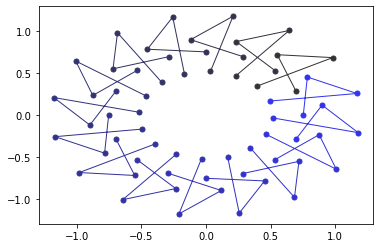

In [18]:
rotated_points = [NQ.as_float_array(q*p_array*q.conj())[:,1:] for q in q_array]

# plot the rotated points:
import matplotlib.pyplot as MPP
for n, rot_p in enumerate(rotated_points):
    MPP.plot(rot_p[:, 0], rot_p[:, 1] \
             , ls = '-' \
             , lw = 1 \
             , markersize = 5 \
             , marker = 'o' \
             , color = (0.2, 0.2, 0.2+0.8*(n/len(rotated_points)))\
            )
    
MPP.show()

{Dancing in circles for this plot: *It just takes 4 elements...*}

For me, `numpy`-quaternions are the bread-and-butter quaternions. 

---

# Advanced Functions <a class="anchor" id="advanced"></a> 
([^](#toc) top) 

Please find here some advanced applications of spatial rotation. 
I share them here from my everyday toolboxes, hoping that their use becomes clear with the comments in the code.

### 1. Finding the Rotation Between Two Objects

using the [Kabsch algorithm](https://en.wikipedia.org/wiki/Kabsch_algorithm?target=_blank); cf. [my blog post on Procrustes Superimposition](../procrustes).

In [19]:

################################################################################
### Data Properties                                                          ###
################################################################################
# The following functions extract features of the data which are relevant.

def Centroid(pointset):
    # the centroid of the data.
    return NP.mean(pointset, axis = 0)


def RCS(pointset):
    # root centroid size, i.e. the scale of the data, defined as the root sum of 
    # euclidean distances of all points from their centroid.
    return NP.sqrt(NP.sum(NP.power(pointset-Centroid(pointset), 2) ))



################################################################################
### Transformation Operations                                                ###
################################################################################
def Center(pointset, trafo_history = None):
    # move all points so that the centroid is at the origin.
    centroid = Centroid(pointset)

    if trafo_history is not None:
        MakeHistory(trafo_history, translate = -centroid, log = 'center')

    return pointset - centroid


def UnitScale(pointset, trafo_history = None):
    # Scale the points so that RCS is one.
    rcs = RCS(pointset)

    if trafo_history is not None:        
        MakeHistory(trafo_history, scale = 1/rcs, log = 'unitscale')

    return pointset / rcs


def Standardize(pointset, trafo_history = None):
    # Standardize a point set, i.e. center and scale to unity.
    pointset = Center(pointset.copy(), trafo_history)
    pointset = UnitScale(pointset, trafo_history)

    return pointset




################################################################################
### Optimal Rotation                                                         ###
################################################################################
def KabschRotation(focal_points, ref_points):
    # optimum rotation matrix to rotate focal points to reference points
    # points must be Nx3 numpy arrays.
    # following https://en.wikipedia.org/wiki/Kabsch_algorithm
    # cf. 
    #   http://nghiaho.com/?page_id=671
    #   https://github.com/charnley/rmsd
    #   http://www.kwon3d.com/theory/jkinem/rotmat.html

    if not (focal_points.shape == ref_points.shape):
        raise IOError('point sets must have the same shape. {} / {}'.format(focal_points.shape, ref_points.shape))

    # deep copy
    focal_points = focal_points.copy()
    ref_points = ref_points.copy()


    # standardize 
    focal_points = Standardize(focal_points)
    ref_points = Standardize(ref_points)


    # calculate cross-dispersion (correlation) matrix
    cross_dispersion = focal_points.T @ ref_points
    
    # singular value decomposition of cross-dispersion matrix
    U,_,V_T = NP.linalg.svd(cross_dispersion, full_matrices = False)
    V = V_T.T

    # check reflection case
    D = NP.eye(3)*NP.array([1., 1., NP.linalg.det(V @ U.T)])

    # return the rotation matrix 
    return V @ D @ U.T



def GetRotationQuaternion(points, refpoints = NP.concatenate([NP.zeros((1,3)), NP.eye(3)], axis = 0)):
    # get the rotation quaternion for a segment
    # by finding optimal rotation between points. 
    # IMPORTANT: The output is a numpy array, and NOT a numpy quaternion.
    #            To apply rotation later, convert it to quaternion with NP.quaternion(*quat)

    rotmat = KabschRotation(points, refpoints)
    quat = NP.roll(ROT.from_matrix(rotmat).as_quat().ravel(), 1) # weird component order in ROT
    quat[0] *= -1 # store the conjugate to get direction right

    return quat

Application: take two sets with the same number of points; at least three (better four). I mostly use this to get segment quaternions in lab coordinates, i.e. relate two coordinate systems to one another and then transform points of interest.

In [20]:
test_points = NP.concatenate([NP.zeros((1,3)), NP.roll(NP.eye(3), 1, axis = 1)], axis = 0)
print (test_points)

GetRotationQuaternion(test_points) # per default, gets the quaternion relative to the global CS

[[0. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]]


array([0.5, 0.5, 0.5, 0.5])

### 2. Quaternion Time Derivatives
These gave me some headache. There are multiple algorithms out, and I tested a lot to find the apparently correct one. I could then analytically confirm [the derivation from a website](http://www.euclideanspace.com/physics/kinematics/angularvelocity/QuaternionDifferentiation2.pdf?target=_blank).

In [21]:
QuatFromArray = lambda arr: NP.array([NP.quaternion(*q) for q in arr])
ArrayFromQuat = lambda quat: NP.stack([NP.append(q.w, q.vec) for q in quat])


### Time Derivatives
def QuaternionDiff(quat, times, lowpass_filter = None):
    dt = NP.mean(NP.diff(times)) 

    
    if lowpass_filter is None:
        quat = quat.copy()
    else: 
        quat = NP.stack([FilT.Smooth(times, quat[:,q].ravel(), lowpass_filter) for q in range(quat.shape[1])], axis = 1)

    from scipy.interpolate import CubicSpline


    ## assure continuity of quaternions in cases where there are sign flips (q ~ -q)
    for i in range(quat.shape[0]):
        q = quat[i, :]
        if NP.sum(NP.abs(NP.sign(q) - NP.sign(quat[i-1, :])) > 0) >= 3:
            quat[i:, :] *= -1

    ## initialize the time derivative of quaternion array
    dquat_dt = NP.gradient(quat, dt, axis = 0, edge_order = 2)
    # dquat_dt_qs = CubicSpline(times, quat).derivative()(times)


    # initialize the second time derivative of quaternion array
    d2quat_dt2 = NP.gradient(dquat_dt, dt, axis = 0, edge_order = 2)
    # d2quat_dt2_qs = CubicSpline(times, quat).derivative(2)(times)
    ## ==> the cubic spline variant looks a bit noisier with Dumas' example.



    # convert all numeric derivatives to quaternion arrays
    quat = QuatFromArray(quat)
    dquat_dt = QuatFromArray(dquat_dt)
    d2quat_dt2 = QuatFromArray(d2quat_dt2)


    ## first derivative:
    # three options:
    # (1) the ang vel formula consistent with https://stackoverflow.com/questions/56790186/how-to-compute-angular-velocity-using-numpy-quaternion
    # also consistent with eqn (3) in http://www.euclideanspace.com/physics/kinematics/angularvelocity/QuaternionDifferentiation2.pdf
    # diff1 = 2* (dquat_dt / quat)

    # # (2) the quaternion differential as in Dumas paper and toolbox
    diff1 = 2 * NP.multiply(dquat_dt, quat.conj())

    # # (3) the numpy ang vel formula.
    # diff1 = NP.quaternion_time_series.angular_velocity(quat, t = times)

    
    ## second derivative:
    # https://physics.stackexchange.com/questions/460311/derivation-for-angular-acceleration-from-quaternion-profile

    # consistent with the formula referenced by Dumas et al.
    diff2 = 2*( NP.multiply(d2quat_dt2, quat.conj()) + NP.multiply(dquat_dt, dquat_dt.conj()) )
    # vector values of the second summand are zero

    # cf. 2
    # https://jamey.thesharps.us/2016/05/16/angular-velocity-and-quaternion
    # http://www.euclideanspace.com/physics/kinematics/angularvelocity/QuaternionDifferentiation2.pdf

    return ArrayFromQuat(diff1)[:, 1:],  ArrayFromQuat(diff2)[:, 1:]



Application:


In [22]:
vel, acc = QuaternionDiff(NQ.as_float_array(q_array), NP.linspace(0., 1., len(q_array), endpoint = True))
vel

array([[0.    , 0.    , 5.9652],
       [0.    , 0.    , 5.8527],
       [0.    , 0.    , 5.8527],
       [0.    , 0.    , 5.8527],
       [0.    , 0.    , 5.8527],
       [0.    , 0.    , 5.8527],
       [0.    , 0.    , 5.8527],
       [0.    , 0.    , 5.8527],
       [0.    , 0.    , 5.8527],
       [0.    , 0.    , 5.8527],
       [0.    , 0.    , 5.8527],
       [0.    , 0.    , 5.8527],
       [0.    , 0.    , 5.8527],
       [0.    , 0.    , 5.8527],
       [0.    , 0.    , 5.8527],
       [0.    , 0.    , 5.9652]])

---

# Application: Joint Configuration Space <a class="anchor" id="app"></a> 
([^](#toc) top) 

There was a presentation and a poster by Armita Manafzadeh at SICB which caught my attention. 
Both were of outstanding quality, I enjoyed watching it and hope the talks will be available after the end of the conference period! 

Armita also has a corresponding paper in JEB, together with Stephen M. Gatesy:

`Manafzadeh, A. R., & Gatesy, S. M. (2020). A coordinate-system-independent method for comparing joint rotational mobilities. Journal of Experimental Biology, 223(18).` [doi: 10.1242/jeb.227108](https://doi.org/10.1242/jeb.227108?target=_blank)

The authors use Euler Space to visualize the range of motion of a joint, which is "industry standard". 
They notice that there is a distortion in Euler space, and that 
> "pairs of poses that are equally different from one another in orientation are not always plotted equally far apart in Euler space."

This is demonstrated on a set of poses. 

In [23]:
Vec2Quat = lambda vec: NQ.quaternion(*NP.append(0, vec))
q1 = Vec2Quat(NP.array([1., 0., 0.]))
print('pose 1:', q1.vec)

rot_y_20 = ROT.from_euler('y', 20, degrees = True)
rot_z_70 = ROT.from_euler('z', 70, degrees = True)
rot_y_58 = ROT.from_euler('y', 58, degrees = True)

Rot2Quat = lambda rotation: NQ.quaternion(*NP.roll(rotation.as_quat(), 1))
q_y_20 = Rot2Quat(rot_y_20)
q_z_70 = Rot2Quat(rot_z_70)
q_y_58 = Rot2Quat(rot_y_58)
q_z70_y20 = q_y_20 * q_z_70
q_z70_y58 = q_y_58 * q_z_70

QRotate = lambda q, rot: rot*q*rot.conj()

q2 = QRotate(q1, q_y_20)
print('pose 2:', q2.vec)


q3 = QRotate(q1, q_z_70)
print('pose 3:', q3.vec)

q4 = QRotate(q1, q_z70_y20)
print('pose 4:', q4.vec)

q5 = QRotate(q1, q_z70_y58)
print('pose 5:', q5.vec)

pose 1: [1. 0. 0.]
pose 2: [ 0.9397  0.     -0.342 ]
pose 3: [0.342  0.9397 0.    ]
pose 4: [ 0.3214  0.9397 -0.117 ]
pose 5: [ 0.1812  0.9397 -0.29  ]


In [24]:
import matplotlib.pyplot as MPP
from mpl_toolkits.mplot3d import proj3d

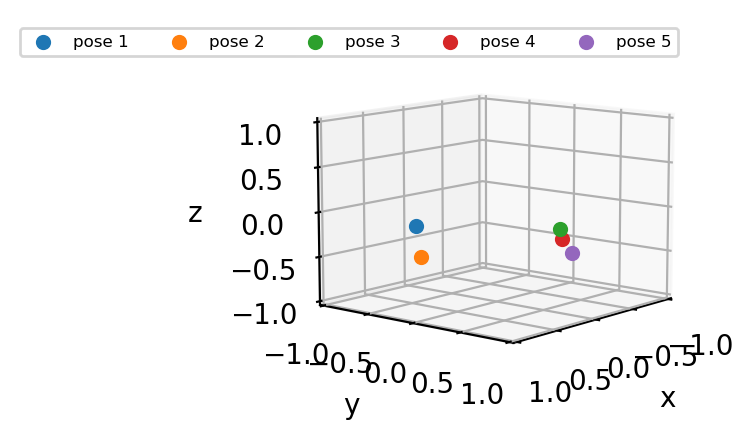

In [25]:
### Visualization
dpi = 200
fig = MPP.figure(dpi = dpi, figsize = (800/dpi, 450/dpi))
ax = fig.add_subplot(1,1,1,projection = '3d')

ax.scatter(*q1.vec, label = 'pose 1')
ax.scatter(*q2.vec, label = 'pose 2')
ax.scatter(*q3.vec, label = 'pose 3')
ax.scatter(*q4.vec, label = 'pose 4')
ax.scatter(*q5.vec, label = 'pose 5')

ax.set_xlim([-1,1])
ax.set_ylim([-1,1])
ax.set_zlim([-1,1])

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')


MPP.tight_layout()
ax.legend(loc = 'best', fontsize = 6, ncol = 5)

ax.view_init(10, 40)
MPP.show()

You see that it appears that the first (blue) and second (orange) pose are equally far apart as the third (green) and fifth (violet) pose. 
This is surprising, because the rotation between "three" and "five" covered a much larger angle. 

This is much more visual in the original paper, because the authors project the points onto a globe. [Make sure to check the original](https://doi.org/10.1242/jeb.227108?target=_blank)!


Using a "cosine-corrected Euler space" which was inspired by an ancient map projection, Manafzadeh and Gatesy manage to restore the expected relation of the poses.


Their cosine transform reminded me of the scaled axis in quaternions. 
Let's plot the poses in "quaternion space":

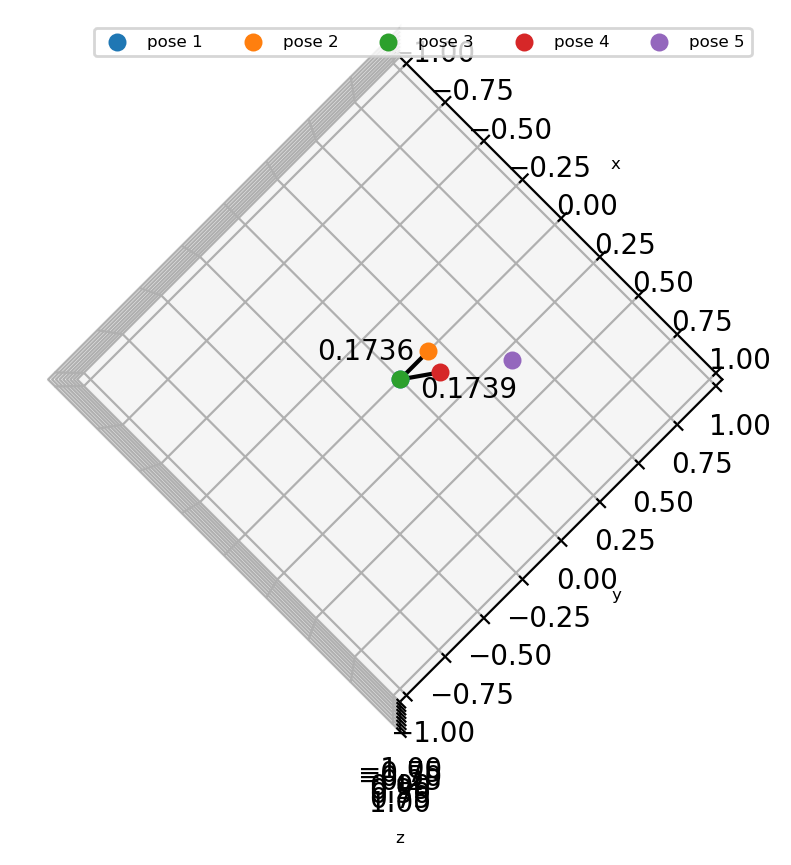

In [26]:
dpi = 200
fig = MPP.figure(dpi = dpi)
ax = fig.add_subplot(1,1,1,projection = '3d')

ax.scatter(0,0,0, s = 30, marker = 'o', label = 'pose 1')
ax.scatter(q_y_20.vec[0], q_y_20.vec[1], q_y_20.vec[2], s = 30, marker = 'o', label = 'pose 2')
ax.scatter(q_z_70.vec[0], q_z_70.vec[1], q_z_70.vec[2], s = 30, marker = 'o', label = 'pose 3')
ax.scatter(q_z70_y20.vec[0], q_z70_y20.vec[1], q_z70_y20.vec[2], s = 30, marker = 'o', label = 'pose 4')
ax.scatter(q_z70_y58.vec[0], q_z70_y58.vec[1], q_z70_y58.vec[2], s = 30, marker = 'o', label = 'pose 5')

ax.legend(loc = 'best', fontsize = 8)

ax.set_xlabel(r'$q_{x}$', fontsize = 6)
ax.set_ylabel(r'$q_{y}$', fontsize = 6)
ax.set_zlabel(r'$q_{z}$', fontsize = 6)

ax.set_xlim([-1,1])
ax.set_ylim([-1,1])
ax.set_zlim([-1,1])


ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')


MPP.tight_layout()
ax.legend(loc = 'best', fontsize = 6, ncol = 5)

ax.view_init(90, -40)

ax.plot([0, q_y_20.vec[0]], [0, q_y_20.vec[1]], [0, q_y_20.vec[2]], color = 'k')
ax.text(q_y_20.vec[0]/2, q_y_20.vec[1]/2, q_y_20.vec[2]/2 \
        , f"{NP.linalg.norm(q_y_20.vec):.4f}" \
        , color = 'k' \
        , ha = 'right', va = 'bottom' \
        , zorder = 100 \
        )


ax.plot([q_z_70.vec[0], q_z70_y20.vec[0]], [q_z_70.vec[1], q_z70_y20.vec[1]], [q_z_70.vec[2], q_z70_y20.vec[2]], color = 'k')
ax.text((q_z_70.vec[0] + q_z70_y20.vec[0])/2, (q_z_70.vec[1] + q_z70_y20.vec[1])/2, (q_z_70.vec[2] + q_z70_y20.vec[2])/2 \
        , f"{NP.linalg.norm(q_z70_y20.vec - q_z_70.vec):.4f}" \
        , color = 'k' \
        , ha = 'left', va = 'top' \
        , zorder = 100 \
        )


MPP.show()

In this space, the relative position of the poses is almost as expected. 
In fact, I cannot exclude a numerical rounding error. 
I would say that the distances match for all practical purposes. 

Is this finding general? Hard to conclude. 
I've been a bit lazy in exploring the "Euler" side, thus lack intuition.


To understand better how these transformations and spaces are related, I took an artificial set of poses which is rectangular in Euler-space.

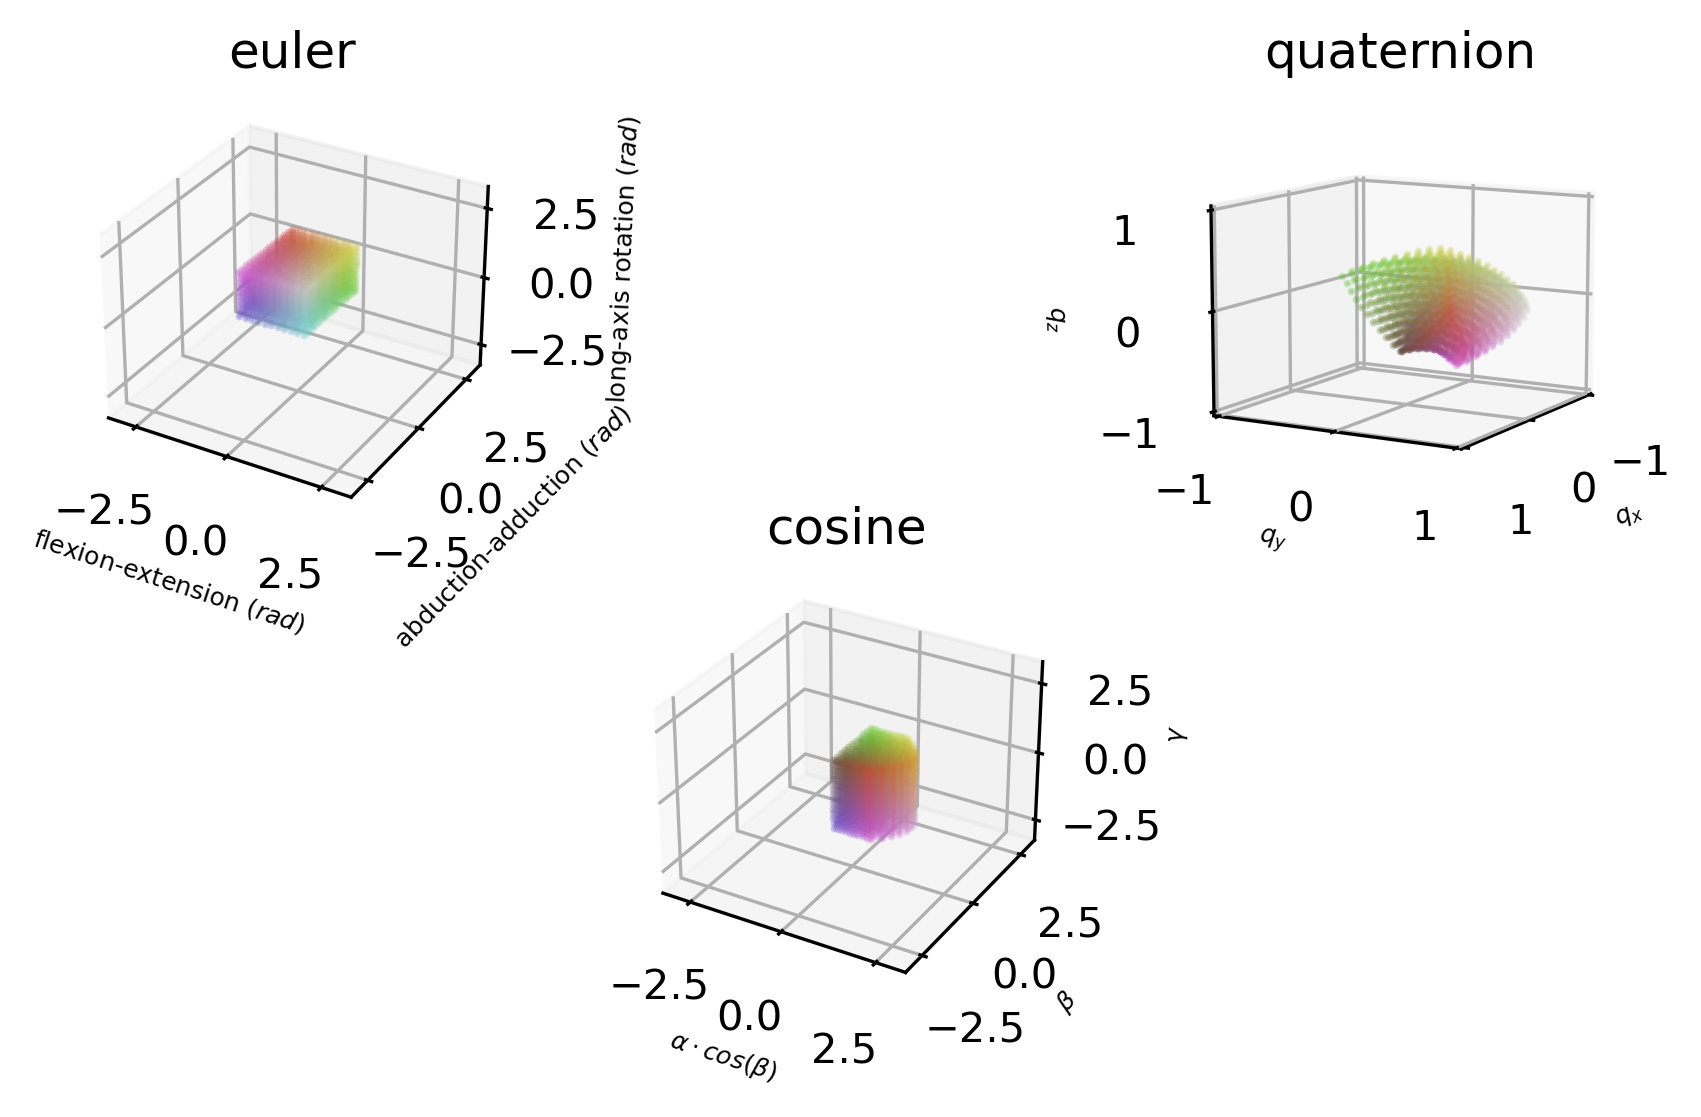

In [27]:

dpi = 300
fig = MPP.figure(dpi = 300, figsize = (1920/dpi, 1080/dpi))
axes = {}
axes['euler'] = fig.add_subplot(2,3,1,projection = '3d')
axes['cosine'] = fig.add_subplot(2,3,5,projection = '3d')
axes['quaternion'] = fig.add_subplot(2,3,3,projection = '3d')

for space, ax in axes.items():
    lim = 1. if space == 'quaternion' else NP.pi
    ax.set_xlim([-1.*lim, 1.*lim])
    ax.set_ylim([-1.*lim, 1.*lim])
    ax.set_zlim([-1.*lim, 1.*lim])

    ax.set_title(space)

axes['euler'].set_xlabel(r'flexion-extension ($rad$)', fontsize = 6, labelpad = 0)
axes['euler'].set_ylabel(r'abduction-adduction ($rad$)', fontsize = 6, labelpad = 0)
axes['euler'].set_zlabel(r'long-axis rotation ($rad$)', fontsize = 6, labelpad = 0)


axes['cosine'].set_xlabel(r'$\alpha \cdot cos\left(\beta \right)$', fontsize = 6, labelpad = 0)
axes['cosine'].set_ylabel(r'$\beta$', fontsize = 6, labelpad = 0)
axes['cosine'].set_zlabel(r'$\gamma$', fontsize = 6, labelpad = 0)

axes['quaternion'].set_xlabel(r'$q_{x}$', fontsize = 6, labelpad = 0)
axes['quaternion'].set_ylabel(r'$q_{y}$', fontsize = 6, labelpad = 0)
axes['quaternion'].set_zlabel(r'$q_{z}$', fontsize = 6, labelpad = 0)

# MPP.tight_layout()
fig.subplots_adjust( \
                          top    = 0.92 \
                        , right  = 0.92 \
                        , bottom = 0.08 \
                        , left   = 0.08 \
                        , wspace = 0.10 # column spacing \
                        , hspace = 0.10 # row spacing \
                        )

# pause
frame = 0
for α in NP.linspace(0, 90, 10, endpoint = True):
    for β in NP.linspace(-50, 50, 11, endpoint = True):
        for γ in NP.linspace(-70, 70, 15, endpoint = True):

            coords = {}
            coords['euler'] = NP.deg2rad([β, γ, α])
            coords['cosine'] = [NP.deg2rad(α) * NP.cos(NP.deg2rad(β)), NP.deg2rad(β), NP.deg2rad(γ)]
            coords['quaternion'] = Rot2Quat(ROT.from_euler('yzx', [α, β, γ], degrees=True)).vec


            for space, ax in axes.items():
                ax.scatter(coords[space][0] \
                          , coords[space][1] \
                          , coords[space][2] \
                          , s = 3 \
                          , marker = '.' \
                          , color = (0.4+0.4*α/90, 0.3+0.5*(β+50)/100, 0.8-0.6*(γ+70)/140) \
                          , alpha = 0.3 \
                          )


            frame += 1

ax.view_init(10, 30)

MPP.show()

Or as an animation:


<video src="images/rotation_spaces.webm" poster="images/rotation_spaces.png" width="800" controls>
</video> 

You can see that the quaternion space is oddly twisted when the Euler space is regular. The same should happen the other way round.


### Response by Armita Manafzadeh
(12 Jan 2020)

Shortly before I created this post, Armita replied to [my question on her poster](https://sicbannualmeeting.pathable.co/meetings/virtual/DjguSphETitrM2mv3 ) without me noticing:

> I initially sought out a quaternion-based solution, but ultimately hoped to find something that had a more clear connection to the (Euler/Tait-Bryan angle) measurements we traditionally take from our Joint Coordinate Systems so that I could easily relate the plots back to the anatomy and communicate with other biologists. This solution secretly relies on quaternions, too -- the volume element for a transformation from the 3-D Tait-Bryan parametrization to the quaternionic parametrization of orientation (where everything plays much nicer mathematically but is stuck in 4-D) has a 1/cosine term, which is what we correct for here! Our JEB paper [[link]](https://doi.org/10.1242/jeb.227108?target=_blank) has an appendix with these calculations, if you're interested. 

This confirms that all the methods for spacial rotation are deeply related, and invites for further explanation. 
Armita also read this text and appreciated my video, and I am thankful for her encouraging feedback!

### Conclusions:

As mentioned in the introductory video, all the different methods of spatial rotation have their advantages and disadvantages. 
Sensing that the beauty of quaternions is underappreciated in Biology due (to their mathematical origin), I would guess that the quaternion axis might be a useful tool to compare ROM estimates or joint configurations in general. 

This does not say that quaternions are generally "better" (whatever that means) than the cosine-corrected Euler angles. In fact, results were slightly off; they seem to be "twisted" (which might be correctable) and are harder to communicate in Biological fields (which I hope to have improved with video and code above). 
On the bright side, quaternions are computational efficient, widely established in other fields, and readily available from almost any rotation-related library. Even [in matlab](https://www.mathworks.com/discovery/quaternion.html?target=_blank)!

Maybe it's worth exploring "quaternion space". 
Or the [other spaces](https://www.youtube.com/watch?v=GBTUVg91bao?target=_blank) related to their concept? Octernions, anyone?

---

As always, I'm up for a discussion and questions, even constructive criticism! Please use the "contact" form or reach out via e-mail. 

<a class="anchor" id="eof"></a> 
([^](#toc) top) 